# Derivatives

Illustrates computing the derivative of the survival function, quantile and TVaR functions. 

Refs:

Tasche
Venter et al ASTIN
Major Forum

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.core.display import HTML, display
from importlib import reload
import re
import pypandoc
import sys
# pandas options 
pd.set_option('max_rows', 50)
pd.set_option('max_columns', 30)
pd.set_option('display.max_colwidth', 150)

# matplotlib and plotting options 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# seaborn options 
sns.set(context='paper', style='darkgrid', font='serif')
# sns.set(context='paper', style='ticks', font='serif')

# warnings
import warnings
# warnings.simplefilter('error')
# warnings.simplefilter('ignore')
import logging
logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

In [14]:
# this file is in examples
sys.path.insert(0,'..')
import aggregate as agg

uw = agg.Underwriter(debug=False)

In [60]:
u = np.array([777, 223, 123])
nu = np.linalg.norm(u)
# for computing derivatives
delta = 1
base_pf = '''port LNExample{i}
    agg A   1 claims sev {ex1} * lognorm 1 cv 0.425 fixed
    agg B   1 claims sev {ex2} * lognorm 1 cv 0.250 fixed
    agg C   1 claims sev {ex3} * lognorm 1 cv 0.350 fixed    '''
xxp = uw(base_pf.format(i=1, ex1=u[0]+delta/2, ex2=u[1], ex3=u[2]))
xxm = uw(base_pf.format(i=1, ex1=u[0]-delta/2, ex2=u[1], ex3=u[2]))
xx0 = uw(base_pf.format(i=1, ex1=u[0], ex2=u[1], ex3=u[2]))
xx0.recommend_bucket()

,bs10,bs11,bs12,bs13,bs14,bs15,bs16,bs18,bs20
line,,,,,,,,,
A,2.460020,1.230010,0.615005,0.307503,0.153751,0.076876,0.038438,0.009609,0.002402
B,0.452154,0.226077,0.113038,0.056519,0.028260,0.014130,0.007065,0.001766,0.000442
C,0.249394,0.124697,0.062349,0.031174,0.015587,0.007794,0.003897,0.000974,0.000244
total,3.161568,1.580784,0.790392,0.395196,0.197598,0.098799,0.049400,0.012350,0.003087


In [61]:
bs = 0.05
N = 17
xxp.update(bs=bs, log2=N, add_exa=True, remove_fuzz=True, padding=2)
xxm.update(bs=bs, log2=N, add_exa=True, remove_fuzz=True, padding=2)
xx0.update(bs=bs, log2=N, add_exa=True, remove_fuzz=True, padding=2)

C:\Users\steve\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:571: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


## 1. Derivative of probability function wrt $t$

$S_u(t) = \int_{\{\sum u_ix_i > t\}} p(x)dx$

Apply IOS formula, parameter is $t$. $p$ is independent of $t$ and so the first term integrating 
$\nabla_u p\equiv 0$. The area of integration is defined by $f(t,x)=t-\sum u_ix_i <0$, with $u_i$ fixed,
$\nabla_t f = 1$ and $\nabla_x f = -(u_1,\dots, u_n)$.

The density $p$ is the density of $(X_1, \dots,X_n)$. Aggregate computes the density of $(u_1X_1,
\dots, u_n X_n)$ and so $p(x)\approx \| u \| p_{total} / bs$ where the additional bucket size factor $bs$ is needed to convert the density over the bucket ```p_total``` into a uniform density. This is integrated over a bucket of size ```bs```.

Therefore the IOS formula gives 
\begin{align}
\nabla_t S(t) &= -\int_{\{\sum u_ix_i=t\}} \frac{\nabla_u f}{\| \nabla_x f \|} p(x) dx \\
&= -\int_{\{\sum u_ix_i=t\}} \frac{1}{\| u \|} p(x) dx \\
&= -\int_{\{\sum u_ix_i=t\}} p_{uX}( x )  dx \\
&= -p_{total} \\
\end{align}
which is kinda obvious...

## 2. Derivative of probability function wrt portfolio weights

$S_u(t) = \int_{\{\sum u_ix_i > t\}} p(x)dx$ where $p$ is the probability density of $(X_1, \dots, X_n)$.

Apply IOS formula, parameters are $u_i$. $p$ is independent of $u$ and so the first term integrating 
$\nabla_u p\equiv 0$. The area of integration is defined by $f(u,x)=t-\sum u_ix_i <0$, with $t$ fixed,
$\nabla_u f = (x_1,\dots, x_n)$ and $\nabla_x f = -(u_1,\dots, u_n)$.

**As above**: The density $p$ is the density of $(X_1, \dots,X_n)$. Aggregate computes the density of $(u_1X_1,
\dots, u_n X_n)$ and so $p(x)\approx \| u \| p_{total} / bs$ where the additional bucket size factor $bs$ is needed to convert the density over the bucket ```p_total``` into a uniform density.

Therefore the IOS formula gives 
\begin{align}
\nabla_u S(t) &= -\int_{\{\sum u_ix_i=t\}} -\frac{\nabla_u f}{\| \nabla_x f \|} p(x) dx \\
&= \int_{\{\sum u_ix_i=t\}} \frac{x_i}{\| \nabla_x f \|} p(x) dx \\
&= \frac{1}{u_i} \int_{\{\sum u_ix_i=t\}} u_i x_i p_{uX}( x )  dx \\
&= \frac{1}{u_i} exeqa(t) \frac{p_{total}}{bs} \\
\end{align}


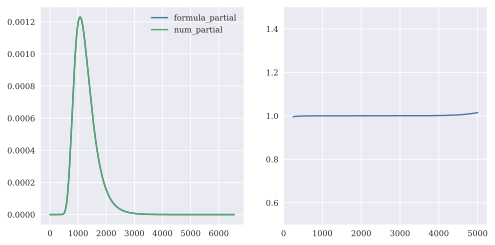

In [62]:
df = pd.DataFrame(dict(xxp=xxp.density_df.S, xxm=xxm.density_df.S, 
                       formula_partial=xx0.density_df.exeqa_A / u[0] * xx0.density_df.p_total / bs))
df.loc[:, 'num_partial'] = (df.xxp - df.xxm)/delta
df.loc[:, 'err'] = df.formula_partial / df.num_partial
f, axs = plt.subplots(1,2,figsize=(8,4))
df.filter(regex='num|form').plot(ax=axs[0])
df.loc[250:5000, 'err'].plot(ax=axs[1], ylim=[0.5,1.5])

## 3. Derivative of Quantile Function (i.e. Value at Risk) 

If $Q$ is the $p$ quantile function then $S(u, Q(u))=p$. The implicit function theorem gives 
$$
S_1 + S_2 \nabla_u Q = 0
$$
where $S_i$ denotes the partial derivative of $S$ wrt the $i$th argument. Hence
$$
\nabla_u Q = -S_1 / S_2.
$$
These two terms were both computed above giving 
$$
\nabla_u Q(p) = \text{E}\left[u_iX_i \mid \sum u_iX_i=Q(p) \right] / u_i.
$$
which is computed numerically as 
$$
\nabla_u Q(p) = \frac{1}{u_i} exeqa(t).
$$

There is roughness in the graphic since VaR is approximated to the nearest multiple of ```bs```.

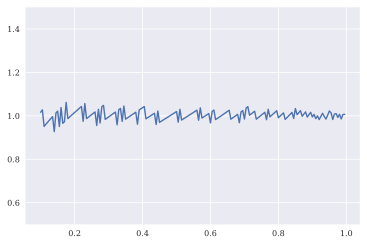

In [68]:
num_diff = []
formula_diff = []
ps = np.arange(0.1, 1, 0.005)
for p in ps:
    num_diff.append( (xxp.q(p) - xxm.q(p)) / delta )
    formula_diff.append(float(xx0.density_df.loc[xx0.q(p), 'exeqa_A'] / u[0]))
diff_test = pd.DataFrame(dict(num_diff=num_diff, formula_diff=formula_diff), index=ps)
diff_test['r1'] = diff_test.formula_diff/diff_test.num_diff
diff_test.r1.plot(ylim=[0.5, 1.5])


## 4. Derivative of Tail Value at Risk

If $T$ is the $p$ TVaR defined as 
$$
T(u, p) = \frac{1}{1-p}\int_{\{\sum u_ix_i>Q(u,p)\}} (\sum u_ix_i) p(x)dx.
$$

If $f=Q-\sum u_ix_i$ then $\nabla_u f=\nabla_u Q - x$ and $\nabla_x f=u$. Hence
$$
\begin{align}
\nabla_u T(p) &= \frac{1}{1-p}\int_{\{\sum u_ix_i>Q(u,p)\}} \nabla_u[Q-(\sum u_ix_i) p(x)]dx \\
&\quad -\frac{1}{\| u\|(1-p)}\int_{\{\sum u_ix_i=Q(u,p)\}} \left(E(X_i\mid \sum u_ix_i=Q)- x_i\right) p(x)dx \\
&= E(X_i\mid \sum u_ix_i>Q(u,p)) \\
\end{align}
$$
since the second term is zero---both expressions evaluating to $E(X_i\mid \sum u_ix_i=Q)$.

,num_diff,formula_diff,r1
0.825,1.699206,1.699255,1.000029
0.850,1.754725,1.754794,1.000039
0.875,1.820204,1.820259,1.000031
0.900,1.900197,1.900289,1.000048
0.925,2.003305,2.003393,1.000044
0.950,2.149002,2.149148,1.000068
0.975,2.400329,2.400583,1.000106


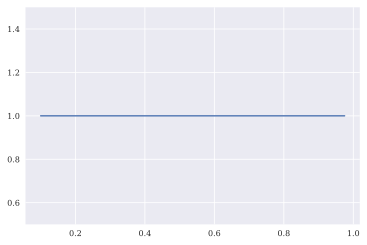

In [65]:
num_diff = []
formula_diff = []
ps = np.arange(0.1, 1, 0.025)
for p in ps:
    num_diff.append( (xxp.TVaR(p) - xxm.TVaR(p)) / delta )
    formula_diff.append(float(xx0.density_df.loc[xx0.q(p), 'exgta_A'] / u[0]))
diff_test = pd.DataFrame(dict(num_diff=num_diff, formula_diff=formula_diff), index=ps)
diff_test['r1'] = diff_test.formula_diff/diff_test.num_diff
diff_test.r1.plot(ylim=[0.5, 1.5])
display(diff_test.loc[.8:1, :])